# In order to run this program successfully, I have added some useful tips to help you understand how the program works. Please read carefully

### 1. Read error messages carefully when an error is encountered. They contain tips on the cuase of the error and how to resolve it
### 2. There is a high chance that cells that contain codes for scrapping data will produce an error on the first run, re-run the cells for a possible fix.
### 3. For some reasons, if you would want to re-scrape the data from any given site, kindly set the re_fetch_data variable to TRUE. I have included these variables in all cells that scrape data.
### 4. Please read the comments if something is unclear to you.
### 5. Scraping the data can take up to 2mins 30secs, be patient while these cells are running
### 6. On each run, the data scrapped might showed some minor difference (as in the number of available flights) but shouldn't lead to very different results from the one presented in this work
### 7. The figures reported in this notebook are temporal. Depending on the data that is actually scrapped, there might be some variations in the figures reported in this notebook.
##### Please send me a mail at myabc360@gmail.com (please do not spam me, this is my personal email account) if you encouter any problem and want a quick fix (Even though I do not expect you to encouter any sort of issues running this notebook, at least, until a year from the time this notebook is published)

In [1]:
# Install selenium and selenium-stealth
!pip install selenium
!pip install selenium-stealth
!apt-get update
!apt install chromium-chromedriver

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.2/400.2 kB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.6 MB/s eta 0:00:00
Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubunt

## Imports

In [2]:
import os
import datetime
from typing import List, Tuple
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import plotly.express as px
sns.set()  # use seaborn plotting styles

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium_stealth import stealth
import time

import warnings
warnings.filterwarnings('ignore')

In [3]:
# set chrome driver options
chrome_options = webdriver.ChromeOptions()
# google colab allows only headless mode. No Graphical User Interface
# disable this locally if you want to see the browser window
chrome_options.add_argument('--headless')
# set window size, click() does not work if window has no size
chrome_options.add_argument('--window-size=1920,1080')
# other options
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_argument('--enable-javascript')

In [4]:
# create a driver object
driver = webdriver.Chrome(options=chrome_options)

In [5]:
# spoof the user agent to get around the bot detection
stealth(driver,
    languages=["en-US", "en"],
    vendor="Google Inc.",
    platform="Win32",
    webgl_vendor="Intel Inc.",
    renderer="Intel Iris OpenGL Engine",
    fix_hairline=True,
)

# Web scraping
## col_names = ['website', airline', 'departure', 'arrival', 'flight_duration_hrs', 'stops_count', 'stop_cities' 'total_layout_time_hrs', 'price']

## Scrapping data from kayak.com

In [6]:
"""
  Kayak and momondu share a similar web structure so I have written a common function that can
  scrape data from both sites
"""
def get_data_from_kayak_momondu(url:str, output_file_name:str, website:str, driver=driver) -> Tuple[bool, pd.DataFrame]:
  """
    Accepts a url, scraps fllight data from the given url using selenium and returns a pandas Dataframe.
    Arguments:
      url: url to scrap flight data from
      output_file_name: name of output file to write data to.
      website: the website from which the data was scrapped.
      driver: selenium driver object that accepts a url and scraps data from the provided url.
    Returns a tuple:
      boolean: a boolean defining the status of the operation performed by the function. Returns True if all went well, False otherwise
      A pandas dataframe containing the scapped dataset
  """
  # 'Show more button'
  btn_class = '//*[@class="ULvh-button show-more-button"]'
  # call driver to get landing page
  driver.get(url)
  # let driver sleep momentarilly as the page gets loaded
  time.sleep(3)

  # click on 'Show more button' until all data on page is loaded
  print("Be patient, the pages are being loaded! The scraping process typically takes around 2 minutes to complete")
  while True:
    try:
      driver.find_element(By.XPATH, btn_class).click()
      time.sleep(3)  # Sleep momentarily to allow page to load
    except:
      break
  # sleep momentarily to allow page to load
  time.sleep(3)
  print("Page loading done!")
  # Select all cards (web elements) that contain flight details
  flight_rows = driver.find_elements(By.XPATH, '//*[@class="nrc6-wrapper"]')
  # There should be at least 50 different flights to choose from. Return False if the lenght of available flights is less than 50
  if len(flight_rows) < 50:
    print(f"Number of available flights: {len(flight_rows)}")
    return (False, None)
  # Else alert user the total number of flights available
  else:
    print(f"Number of available flights: {len(flight_rows)}")
  # A list of dictionaries containing flight details
  flight_lists = []
  print("Flights details are being extracted. Please be patient")
  # Iterate over the fligh rows, getting details from each row
  for webElement in flight_rows:
      elementHTML = webElement.get_attribute('outerHTML')
      elementSoup = BeautifulSoup(elementHTML, 'html.parser')
      price_ = elementSoup.find("div", {"class": "f8F1-price-text"}).text
      flight_company_ = elementSoup.find("div", {"class": "c_cgF c_cgF-mod-variant-default"}).text
      sub_soup = elementSoup.find('div', {"class": "vmXl vmXl-mod-variant-large"}) # contains flights take-off and arrival times
      flight_times = sub_soup.find_all('span')
      take_off_ = flight_times[0].text  # take off time
      landing_ = flight_times[2].text   # arrival time
      stops_cnt = elementSoup.find("span", {"class": "JWEO-stops-text"}).text    # number of stops before final destination
      flight_dur_soup = elementSoup.find("div", {"class": "xdW8"})
      flight_duration = flight_dur_soup.find("div", {"class": "vmXl vmXl-mod-variant-default"}).text
      fl_dur_hours = flight_duration.split(' ')[0][:-1]
      fl_dur_mins = flight_duration.split(' ')[1][:-1]
      flight_duration_ = fl_dur_hours + "." + fl_dur_mins    # total fligh duration in hours
      s_dsts = elementSoup.find("div", {"class": "JWEO"})
      stop_dsts = s_dsts.find("div", {"class": "c_cgF c_cgF-mod-variant-default"}) #
      layover_time_ = 0.0   # Get all stop points of the flight if any
      stop_cities = ""    # cities where there is a layover
      if stop_dsts:
          stops = stop_dsts.find_all("span")
          for stop in stops:
              try:
                # we need only first 2 values, they contain hr and min info respectively.
                # For instance, this is an example result representing 'stop':  (1h 45m layover, <b>Kastrup Copenhagen</b>)
                layover_info = stop.find("span")['title']
                stop_city_info = layover_info  # layover_info also contains info about the layover cities
                layover_info = str(layover_info).split(" ")[:2]   # only take the value for the time.
                hr = layover_info[0][:-1]  # only take the number representing the hour
                min = layover_info[1][:-1]  # only take the number representing the mins
                # Since we are representing the number of hours in float, we need to change the scale of mins from 60 to 100
                # for instance, 30 mins becomes 50. So 3 hrs 45 mins becomes 3.75  hrs
                min = (int(min)/60)
                time_in_hrs = int(hr) + min
                layover_time_ += time_in_hrs
                st_city_info = stop_city_info.replace("<b>", "").replace("</b>", "") # replace the bold text tags with empty string.
                stop_cities += st_city_info + ". "  # concatenate the two strings, add a period(.) and then a space.
              except:
                  pass
      flight_lists.append({
          'website': website,
          'airline': flight_company_,
          'departure': take_off_,
          'arrival': landing_,
          'flight_duration_hrs': float(flight_duration_),
          'stops_count': stops_cnt,
          'layover_info': stop_cities.strip(),   # strip off any leading or trailing whitespaces.
          'total_layover_time_hrs': round(layover_time_, 2),
          'price': price_ })
  # Create a dataframe from the list of dictionaries containing flight details
  kayak_flights = pd.DataFrame.from_dict(flight_lists)
  # Save data to a csv file
  kayak_flights.to_csv(output_file_name, index=0)
  return (True, kayak_flights)

#### Please read the output from the cell below if an error is encountered. (Re-running the cell might lead to a possible fix!)

In [8]:
# There is a high chance that this cell will thorw an eror upon the first run. Re-run it for a possible fix!)
re_fetch_data:bool = False    # Set this to true if for some reasons you would like to re-scrape the data
kayak_data_url = 'https://www.kayak.com/flights/HEL-ARN/2023-11-27?sort=bestflight_a&fs=cfc=0;baditin=baditin;bfc=0;airports=ARN,HEL'
data_file = "kayak_data.csv"
# Only scap data if not alreading in working directory. This is to avoid rescrapping the data each time this cell is run
if (not data_file in os.listdir()) or re_fetch_data:
  start = time.time()
  # scrap data if not existing already
  status, kayak_data = get_data_from_kayak_momondu(kayak_data_url, output_file_name="kayak_data.csv", website="kayak.com")
  if not status:
    msg = ("Number of available flights is less than 50 or number of scapped flight details is less than 50! "
           "Re-run this cell for a possible fix")
    print(f"{msg}")
  else:
    stop = time.time()
    elapsed_time = stop - start
    print(f"Data scrapped successfully in {round(elapsed_time, 2)} seconds!\n")     # to 2 decimal places
else:
  kayak_data = pd.read_csv(data_file)
  print("The data already exists. Lucky you! You don't have to wait :)")
kayak_data.head()


Be patient, the pages are being loaded! The scraping process typically takes around 2 minutes to complete
Page loading done!
Number of available flights: 248
Flights details are being extracted. Please be patient
Data scrapped successfully in 106.55 seconds!



,website,airline,departure,arrival,flight_duration_hrs,stops_count,layover_info,total_layover_time_hrs,price
0,kayak.com,Norwegian,7:45 pm,7:45 pm,1.0,nonstop,,0.0,$39
1,kayak.com,Norwegian,7:45 pm,7:45 pm,1.0,nonstop,,0.0,$36
2,kayak.com,Norwegian,4:40 pm,4:40 pm,1.0,nonstop,,0.0,$36
3,kayak.com,Norwegian,7:40 am,7:50 am,1.1,nonstop,,0.0,$36
4,kayak.com,Norwegian,9:15 am,9:15 am,1.0,nonstop,,0.0,$46


## Scrapping data from Hotwire.com

In [9]:
def get_hotwire_data(url:str, website:str="hotwire.com",driver=driver) -> Tuple[bool, pd.DataFrame]:
  """
    Accepts a url, scraps fllight data from the given url using selenium and returns a pandas Dataframe.
    Arguments:
      url: url to scrap flight data from
      website: the website from which the data was scrapped from.
      driver: selenium driver object that accepts a url and scraps data from the provided url.
    Returns a tuple:
      boolean: a boolean defining the status of the operation performed by the function. Returns True if all went well, False otherwise
      A pandas dataframe containing the scapped dataset
  """
  # show more button
  show_more_btn_class =  'button[class="uitk-button uitk-button-medium uitk-button-has-text uitk-button-primary"]'
  # call driver to get landing page
  driver.get(url)
  # let driver sleep momentarilly as the page gets loaded
  time.sleep(2)

  print("Be patient, the pages are being loaded! The scraping process typically takes around 30 seconds to complete")
  driver.find_element(By.CSS_SELECTOR, show_more_btn_class).click()  # click on show more button
  time.sleep(10)  # Sleep momentarily to allow page to fully load
  print("Pages loaded successfully!")
  # Select all cards (web elements) that contain flight details
  flight_lists = []
  flight_cards_class = ('//*[@class="uitk-layout-grid uitk-layout-grid-has-auto-columns '
                                                  'uitk-layout-grid-display-grid"]')
  flight_rows = driver.find_elements(By.XPATH, flight_cards_class)
  if len(flight_rows) < 50:
    print(f"Number of flights available: {len(flight_rows)}")
    return (False, None)
  # Else alert user the total number of flights available
  else:
    print(f"Number of available flights: {len(flight_rows)}")

  # A list of dictionaries containing flight details
  flight_lists = []
  print("Flights details are being extracted. Please be patient")
  # Iterate over the fligh rows, getting details from each row
  for webElement in flight_rows:
      elementHTML = webElement.get_attribute('outerHTML')
      elementSoup = BeautifulSoup(elementHTML, 'html.parser')
      flight_company_ = elementSoup.find("div", {"data-test-id": "flight-operated"}).text
      if '•' in flight_company_:
        flght_company_name = flight_company_.split('•')[0]
      else:
        flight_company_name = flight_company_
      departure_arrival = elementSoup.find("span", {"data-test-id": "departure-time"}).text  # departure-arrival times are in the same element
      departure_ = departure_arrival.split("-")[0].strip()
      arrival_ = departure_arrival.split("-")[1].strip()
      duration_stop_cnt = elementSoup.find("div", {"data-test-id": "journey-duration"}).text # duration and stop counts -> same element
      dur = duration_stop_cnt.split('(')[0].strip()
      try:
        hrs = dur.split(" ")[0][:-1]
        mins = dur.split(" ")[1][:-1]
        duration_ = int(hrs) + (int(mins)/60)
      except:
        duration_ = int(dur[:-1]) / 60
      stops_cnt_ = duration_stop_cnt.split('(')[1][:-1].strip()
      stop_cities = ""
      # Avoid error for flights that have no layovers
      total_layover_time = 0.0
      try:
        layovers = elementSoup.find("div", {"data-test-id": "layovers"}).text
        layover_info = layovers.replace("•", ".")
        stop_cities += layover_info     # concatenate the two strings.
        # maximum stops is 2
        stop_points = layovers.split("•")
        for stop in stop_points:
          layover_hr_m = stop.split('m')[0]
          if 'h' in layover_hr_m:
            hr = layover_hr_m.split(' ')[0][:-1].strip()   # only consider the num (i.e 2h -> 2. the 'h' is not needed)
            hr = int(hr)     # convert to an int
            mins = layover_hr_m.split(' ')[1].strip()      # the 'm' at the end has already been stripped off.
            mins = int(mins) / 60
            total_time = hr + mins
            total_layover_time += total_time
          else:    # if h is not in the layover_hr_m string, then the time only contains minutes
            mins = layover_hr_m.strip()
            total_time = int(mins) / 60
            total_layover_time += total_time
      except:
        pass
      price_ = elementSoup.find("span", {"class": "uitk-lockup-price"}).text
      flight_lists.append({
          'website': website,
          'airline': flight_company_name,
          'departure': departure_,
          'arrival': arrival_,
          'flight_duration_hrs': round(duration_, 2),
          'stops_count': stops_cnt_,
          'layover_info': stop_cities.strip(),   # remove leading and trailing whitespaces
          'total_layover_time_hrs': round(total_layover_time, 2),   # round to 2 decimal places -> 1.33333 => 1.33
          'price': price_ })
  hotwire_flights = pd.DataFrame.from_dict(flight_lists)
  # Save data to a csv file
  hotwire_flights.to_csv("hotwire_data.csv", index=0)
  return (True, hotwire_flights)


#### Please read the output from the cell below if an error is encountered. (Re-running the cell might lead to a possible fix!)

In [10]:
hotwire_url = ('https://vacation.hotwire.com/Flights-Search?tmid=33731775767&trip=OneWay&leg1=from:HEL,'
'to:ARN,departure:11/27/2023TANYT&passengers=adults:1,&options=sortby:price&mode=search&paandi=true')

re_fetch_data:bool = False    # Set this to true if for some reasons you would like to re-scrape the data
data_file = "hotwire_data.csv"
# Only scap data if not alreading in working directory. This is to avoid rescrapping the data each time this cell is run
if (not data_file in os.listdir()) or re_fetch_data:
  start = time.time()
  status, hotwire_data = get_hotwire_data(hotwire_url)   # scrap data if not existing already
  if not status:
    error_msg = ("Number of available flights is less than 50 or number of scapped flight "
     "details is less than 50! Re-run this cell for a possible fix.")
    print(f"{error_msg}")
  else:
    stop = time.time()
    elapsed_time = stop - start
    print(f"Data scrapped successfully in {round(elapsed_time, 2)} seconds!\n")

else:
  hotwire_data = pd.read_csv(data_file)
  print("The data already exists. Lucky you! You don't have to wait :)")
hotwire_data.head(5)    # this line will throw an error is the data wasn't able to be scrapped.

Be patient, the pages are being loaded! The scraping process typically takes around 30 seconds to complete
Pages loaded successfully!
Number of available flights: 88
Flights details are being extracted. Please be patient
Data scrapped successfully in 30.03 seconds!



,website,airline,departure,arrival,flight_duration_hrs,stops_count,layover_info,total_layover_time_hrs,price
0,hotwire.com,Norwegian Air International Ltd,4:40pm,4:40pm,1.00,Nonstop,,0.00,$47
1,hotwire.com,Norwegian Air International Ltd,7:45pm,7:45pm,1.00,Nonstop,,0.00,$47
2,hotwire.com,Norwegian Air International Ltd,7:40am,7:50am,1.17,Nonstop,,0.00,$47
3,hotwire.com,Norwegian Air International Ltd,9:15am,9:15am,1.00,Nonstop,,0.00,$58
4,hotwire.com,Air Baltic,5:20am,7:20am,3.00,1 stop,45m in Riga (RIX),0.75,$67


## Scrapping data from Momondu.com

#### Please read the output from the cell below if an error is encountered. (Re-running the cell might lead to a possible fix!)

In [11]:
# There is a high chance that running this cell for the first time will throw an error. Re-run the cell for a possible fix.
re_fetch_data:bool = False    # Set this to true if for some reasons you would like to re-scrape the data
momondu_url = 'https://www.momondo.com/flight-search/HEL-ARN/2023-11-27?sort=bestflight_a&fs=cfc=0;baditin=baditin;bfc=0;airports=BMA,ARN,HEL'

data_file = "momondu_data.csv"
# Only scap data if not alreading in working directory. This is to avoid rescrapping the data each time this cell is run
if (not data_file in os.listdir()) or re_fetch_data:
  start = time.time()
  # scrap data if not existing already
  status, momondu_data = get_data_from_kayak_momondu(momondu_url, output_file_name="momondu_data.csv", website="momondu.com")
  if not status:
    msg = ("Number of available flights is less than 50 or number of scapped flight details is less than 50! "
           "Re-run this cell for a possible fix")
    print(f"{msg}")
  else:
    stop = time.time()
    elapsed_time = stop - start
    print(f"Data scrapped successfully in {round(elapsed_time, 2)} seconds!\n")
else:
  momondu_data = pd.read_csv(data_file)
  print("The data already exists. Lucky you! You don't have to wait :)")
momondu_data.head()


Be patient, the pages are being loaded! The scraping process typically takes around 2 minutes to complete
Page loading done!
Number of available flights: 228
Flights details are being extracted. Please be patient
Data scrapped successfully in 109.99 seconds!



,website,airline,departure,arrival,flight_duration_hrs,stops_count,layover_info,total_layover_time_hrs,price
0,momondu.com,Norwegian,7:45 pm,7:45 pm,1.0,nonstop,,0.0,$39
1,momondu.com,Norwegian,7:45 pm,7:45 pm,1.0,nonstop,,0.0,$36
2,momondu.com,Norwegian,4:40 pm,4:40 pm,1.0,nonstop,,0.0,$36
3,momondu.com,Norwegian,7:40 am,7:50 am,1.1,nonstop,,0.0,$36
4,momondu.com,Norwegian,9:15 am,9:15 am,1.0,nonstop,,0.0,$46


In [12]:
# We are done scraping the data. Let's quit the driver object
# If you want to rescrape the data, then you will need to scroll up to run the cell that initializes the driver object.
driver.quit()

# Data Preprocessing

##### Let's first have a look at the unique airlines we have from the different datasets

In [13]:
hotwire_data.airline.unique()

array(['Norwegian Air International Ltd', 'Air Baltic', 'Finnair',
       'Norwegian Air Shuttle', 'Multiple airlines', 'KLM', 'Lufthansa',
       'Scandinavian Airlines'], dtype=object)

In [14]:
momondu_data.airline.unique()

array(['Norwegian', 'Finnair', 'Scandinavian Airlines',
       'Braathens Regional Aviation', 'airBaltic', 'airBaltic, Ryanair',
       'Norwegian, Scandinavian Airlines',
       'airBaltic, Scandinavian Airlines', 'airBaltic, Norwegian',
       'Multiple airlines', 'Finnair, Ryanair', 'Air France',
       'Scandinavian Airlines, Norwegian', 'KLM',
       'Norwegian, Ethiopian Air', 'Lufthansa', 'British Airways',
       'Lufthansa, Scandinavian Airlines', 'Norwegian, Wizz Air',
       'Austrian Airlines', 'Ryanair', 'SWISS', 'Ryanair, Norwegian',
       'airBaltic, LOT', 'Brussels Airlines', 'Turkish Airlines',
       'Ryanair, Wizz Air', 'Qatar Airways', 'Ryanair, Wizz Air Malta'],
      dtype=object)

In [15]:
kayak_data.airline.unique()

array(['Norwegian', 'Finnair', 'Scandinavian Airlines', 'airBaltic',
       'airBaltic, Ryanair', 'Norwegian, Scandinavian Airlines', 'KLM',
       'Finnair, Ryanair', 'airBaltic, Scandinavian Airlines',
       'Air France', 'Lufthansa', 'Scandinavian Airlines, Norwegian',
       'airBaltic, Norwegian', 'Norwegian, Ethiopian Air',
       'Multiple airlines', 'Norwegian, Wizz Air', 'British Airways',
       'Austrian Airlines', 'Lufthansa, Scandinavian Airlines',
       'Finnair, Scandinavian Airlines', 'Finnair, airBaltic', 'SWISS',
       'Ryanair', 'Finnair, LOT', 'Ryanair, Norwegian',
       'Brussels Airlines', 'airBaltic, LOT', 'Turkish Airlines',
       'Ryanair, Wizz Air', 'Qatar Airways', 'Ryanair, Wizz Air Malta'],
      dtype=object)

##### It can be seen that, data scrapped from kayak and momendu follow the same convention. However, some of the flight company names is different for data scrapped from hotwire. We need to write a helper function to fix this.

In [16]:
# helper function to fix flight company names for data scrapped from hotwire.com (necessary for visualisation)
def map_fligt_company_name(flight_company:str) -> str:
  """
    Maps a given flight company name to the desired name:
    Arguments:
      flight_company: str -> name of company that needs to be mapped to the desired name.
    Return:
      The the desired flight company name: str
  """
  if flight_company.lower().strip() == "norwegian air international ltd":
    flight_company = "Norwegian"
  elif flight_company == "Air Baltic":
    flight_company = "airBaltic"
  else:
    flight_company = flight_company   # all other flight company names are okay!
  return flight_company


##### Next, the flight stops counts is in a string format. Let's convert them to integers to help users determine how many stops there are in between departure and arrival

In [17]:
# Let's find the unique values we have for the stops_count column for all data sets
kayak_data.stops_count.unique()

array(['nonstop', '1 stop', '2 stops'], dtype=object)

In [18]:
momondu_data.stops_count.unique()

array(['nonstop', '1 stop', '2 stops'], dtype=object)

In [19]:
hotwire_data.stops_count.unique()

array(['Nonstop', '1 stop', '2 stops'], dtype=object)

#### Huhuuuuu! Ignoring lower and upper cases, all the data sets contain the same set of options (nonstop, 1 stop, 2 stops, 3 stops).


### Let's write a helper function to transform these values into integer values

In [20]:
def stops_counts_to_int(stops_count:str) -> int:
  """
    Transforms a string representing the stops count to integer.
    Arguments:
      stops_counts:str -> a string representing stops count
    Returns:
      An int representing the number of stop points in between departure and destination.
  """
  if stops_count.lower() == 'nonstop':
    stops_count = 0
  elif stops_count.lower() == '1 stop':
    stops_count = 1
  elif stops_count.lower() == '2 stops':
    stops_count = 2
  else:
    stops_count = 3       # By inspection, the highest number of stop points I have seen is 3. This could change in the future
  return stops_count      # but let's ignore that for now

In [21]:
# before applying the transformations, it's better to concatenate our dataframes into one big dataframe.
dataframes = [kayak_data, momondu_data, hotwire_data]   # list of all dataframe objects to concatenate
flights_data = pd.concat(dataframes, ignore_index=True)                    # concate all the dataframe to form one big flight data
flights_data.head()

,website,airline,departure,arrival,flight_duration_hrs,stops_count,layover_info,total_layover_time_hrs,price
0,kayak.com,Norwegian,7:45 pm,7:45 pm,1.0,nonstop,,0.0,$39
1,kayak.com,Norwegian,7:45 pm,7:45 pm,1.0,nonstop,,0.0,$36
2,kayak.com,Norwegian,4:40 pm,4:40 pm,1.0,nonstop,,0.0,$36
3,kayak.com,Norwegian,7:40 am,7:50 am,1.1,nonstop,,0.0,$36
4,kayak.com,Norwegian,9:15 am,9:15 am,1.0,nonstop,,0.0,$46


In [22]:
print(f"There are {flights_data.shape[0]} flights in total!")

There are 564 flights in total!


#### Huraaaaaay! We are on our way to success. Now let's apply the stops_counts_to_int function to transform the stops_count feature column
#### And the map_fligt_company_name transformation funciton to the airline feature column

In [23]:
# map the stop counts feature to integer values
try:
  flights_data['stops_count'] = flights_data['stops_count'].apply(stops_counts_to_int)
except AttributeError:
  print("Transformation function has already been applied")
flights_data.stops_count.unique()

array([0, 1, 2])

In [24]:
# apply the transformation helper function defined above to the airline feature
flights_data['airline'] = flights_data['airline'].apply(map_fligt_company_name)
# check that the transformation was successfully
flights_data.airline.unique()

array(['Norwegian', 'Finnair', 'Scandinavian Airlines', 'airBaltic',
       'airBaltic, Ryanair', 'Norwegian, Scandinavian Airlines', 'KLM',
       'Finnair, Ryanair', 'airBaltic, Scandinavian Airlines',
       'Air France', 'Lufthansa', 'Scandinavian Airlines, Norwegian',
       'airBaltic, Norwegian', 'Norwegian, Ethiopian Air',
       'Multiple airlines', 'Norwegian, Wizz Air', 'British Airways',
       'Austrian Airlines', 'Lufthansa, Scandinavian Airlines',
       'Finnair, Scandinavian Airlines', 'Finnair, airBaltic', 'SWISS',
       'Ryanair', 'Finnair, LOT', 'Ryanair, Norwegian',
       'Brussels Airlines', 'airBaltic, LOT', 'Turkish Airlines',
       'Ryanair, Wizz Air', 'Qatar Airways', 'Ryanair, Wizz Air Malta',
       'Braathens Regional Aviation', 'Norwegian Air Shuttle'],
      dtype=object)

In [25]:
flights_data.head()

,website,airline,departure,arrival,flight_duration_hrs,stops_count,layover_info,total_layover_time_hrs,price
0,kayak.com,Norwegian,7:45 pm,7:45 pm,1.0,0,,0.0,$39
1,kayak.com,Norwegian,7:45 pm,7:45 pm,1.0,0,,0.0,$36
2,kayak.com,Norwegian,4:40 pm,4:40 pm,1.0,0,,0.0,$36
3,kayak.com,Norwegian,7:40 am,7:50 am,1.1,0,,0.0,$36
4,kayak.com,Norwegian,9:15 am,9:15 am,1.0,0,,0.0,$46


### Everything going good! Now, the price column needs a little bit of preprocessing. we need to remove the dollar sign and rename the column to something like price_in_dollars to let the user know which currency they are dealing in.

In [26]:
def remove_dollar_sign(price_with_dollar_sign:str) -> float:
  """
    Takes a string representing  price, removes the dollar sign and returns the price in dollars.
    Arguments:
      price_with_dollar_sign:str -> a string representing the price
    Returns:
      A float representing the cost of the flight in dollars.
  """
  # Just slice off the first character ($) and replace commas with an empty string. Hence, $2,527 become 2527!
  price_without_dollar_sign = price_with_dollar_sign[1:].replace(',', '')  # remove the commas as well
  return float(price_without_dollar_sign)

In [27]:
try:
  flights_data['price_in_dollars'] = flights_data['price'].apply(remove_dollar_sign)
  flights_data.drop(['price'], axis=1, inplace=True)   # drop the original price column (the one with the dollar sign)
except:
  print("You already dropped the 'price' column, mate")
flights_data.head()

,website,airline,departure,arrival,flight_duration_hrs,stops_count,layover_info,total_layover_time_hrs,price_in_dollars
0,kayak.com,Norwegian,7:45 pm,7:45 pm,1.0,0,,0.0,39.0
1,kayak.com,Norwegian,7:45 pm,7:45 pm,1.0,0,,0.0,36.0
2,kayak.com,Norwegian,4:40 pm,4:40 pm,1.0,0,,0.0,36.0
3,kayak.com,Norwegian,7:40 am,7:50 am,1.1,0,,0.0,36.0
4,kayak.com,Norwegian,9:15 am,9:15 am,1.0,0,,0.0,46.0


#### One thing I would like to do before proceeding is to convert the departure times to 24 hr format. i.e, 1 pm -> 13:00. Let's define a helper function as usual.

In [28]:
def transform_dearture_col(data_frame:pd.DataFrame) -> pd.DataFrame:
  """
    Converts time from 12 hours format to 24 hours format.
    Arguments:
      data_frame: the dataframe whose departure column is to be transformed.
    Returns:
      dataframe object with the new transformed departure column
  """
  data_frame['departure'] = pd.to_datetime(data_frame['departure']).dt.strftime("%H:%M")
  return data_frame

In [29]:
# let's apply the time to 24 hrs format function to the departure feature.
# the function takes the dataframe, transforms the departure column and returns the new dataframe
flights_df = transform_dearture_col(flights_data)
flights_df.head()

,website,airline,departure,arrival,flight_duration_hrs,stops_count,layover_info,total_layover_time_hrs,price_in_dollars
0,kayak.com,Norwegian,19:45,7:45 pm,1.0,0,,0.0,39.0
1,kayak.com,Norwegian,19:45,7:45 pm,1.0,0,,0.0,36.0
2,kayak.com,Norwegian,16:40,4:40 pm,1.0,0,,0.0,36.0
3,kayak.com,Norwegian,07:40,7:50 am,1.1,0,,0.0,36.0
4,kayak.com,Norwegian,09:15,9:15 am,1.0,0,,0.0,46.0


#### Oh yesssssssssssss! Time for visualization? But just before that, let's double check for null values and have a quich statistical description of our dataset

In [30]:
flights_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 564 entries, 0 to 563
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   website                 564 non-null    object 
 1   airline                 564 non-null    object 
 2   departure               564 non-null    object 
 3   arrival                 564 non-null    object 
 4   flight_duration_hrs     564 non-null    float64
 5   stops_count             564 non-null    int64  
 6   layover_info            564 non-null    object 
 7   total_layover_time_hrs  564 non-null    float64
 8   price_in_dollars        564 non-null    float64
dtypes: float64(3), int64(1), object(5)
memory usage: 39.8+ KB


#### Yhaaaaaay! No null values. ✅ Let's have a quick statistical overview of the dataset

In [31]:
flights_df.describe()

,flight_duration_hrs,stops_count,total_layover_time_hrs,price_in_dollars
count,564.000000,564.000000,564.000000,564.000000
mean,12.431401,1.287234,8.348865,585.460993
std,7.510307,0.635632,6.850279,494.361012
min,1.000000,0.000000,0.000000,36.000000
25%,7.000000,1.000000,2.420000,144.000000
50%,11.250000,1.000000,6.625000,304.000000
75%,17.600000,2.000000,13.602500,981.000000
max,31.100000,2.000000,25.000000,1939.000000


#### From the information above, we can make the following conclusions
##### 1. The longest layover is around 26 hours 30 minutes, over a day! With the highest flight duration being over 29 hours!
##### 2. The most expensive flight ticket is 1947 dollars with the cheapest being 32 dollars!
##### 3. And obviously the highest number of stops between the two destinations is 2 stops.
##### 4. Also notice that most of the flight duration lasts around 12.07 hours, which is a lot in my opinion.
#### Please note that the quoted figures might show a little bit of difference if you're tyring to check this work later on. This is due to the fact that the data scrapped might vary a bit.

In [32]:
# Before proceeding, let's save the preprocessed data and a create a copy of it to avoid overwriting it accidentally
# We can always come back to this cell and get a fresh copy of the dataset
# Checkpoints are greaaaaaat!
flights_df.to_csv("preprocessed_flights_data.csv")  # save the preprocessed data
flights_dataset = flights_df.copy()

# Visualisation, the power house of insights!

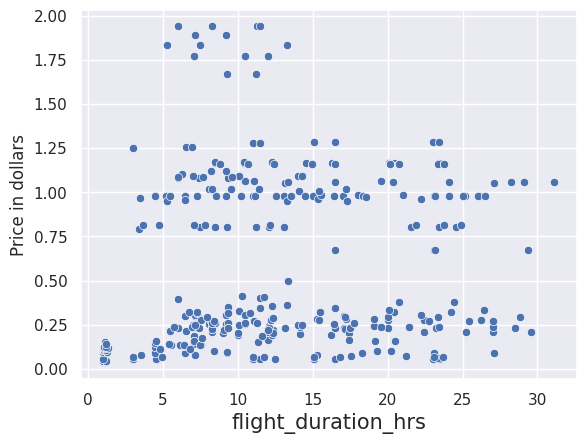

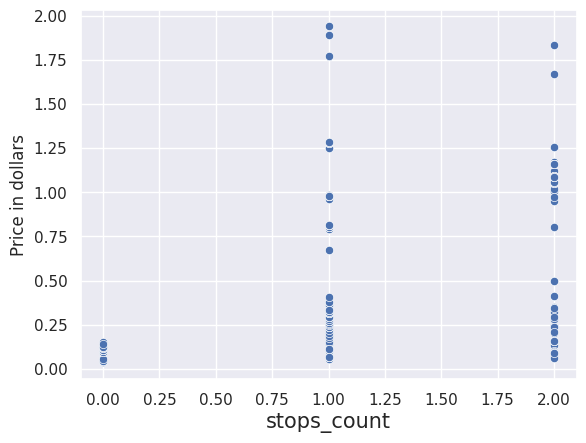

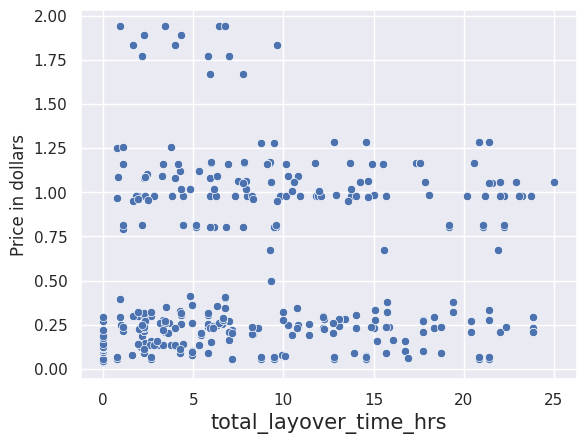

In [33]:
# Let's begin by doing a few visualizations on the dataset
# Let's first draw scatter plots to explore how flight_duration_hrs,	stops_count, and	total_layover_time_hrs
# vary with the price.
cols_to_viz = ['flight_duration_hrs',	'stops_count',	'total_layover_time_hrs']
for col in cols_to_viz:
  sns.scatterplot(data=flights_dataset, x=col, y=(flights_dataset['price_in_dollars'])/1000)
  plt.xlabel(col, fontdict={'size':15})
  plt.ylabel('Price in dollars')
  plt.show()

###### It can be seen from the graphs above that, by considering duration of a flight and how much it costs, three groups can be identified. We might explore these groups later on. Also, it is obvious from the graphs above that, direct flights costs way less than flights that have one or more stops. Aside that, I don't see anything too interesting. But let's try to find out how the numerical features correlate with one another.

In [34]:
flights_dataset.corr()

,flight_duration_hrs,stops_count,total_layover_time_hrs,price_in_dollars
flight_duration_hrs,1.000000,0.375010,0.931514,0.219002
stops_count,0.375010,1.000000,0.263254,0.295973
total_layover_time_hrs,0.931514,0.263254,1.000000,0.187949
price_in_dollars,0.219002,0.295973,0.187949,1.000000


###### Let's first use a heatmap to visualize the correclations and then draw our conclusions.

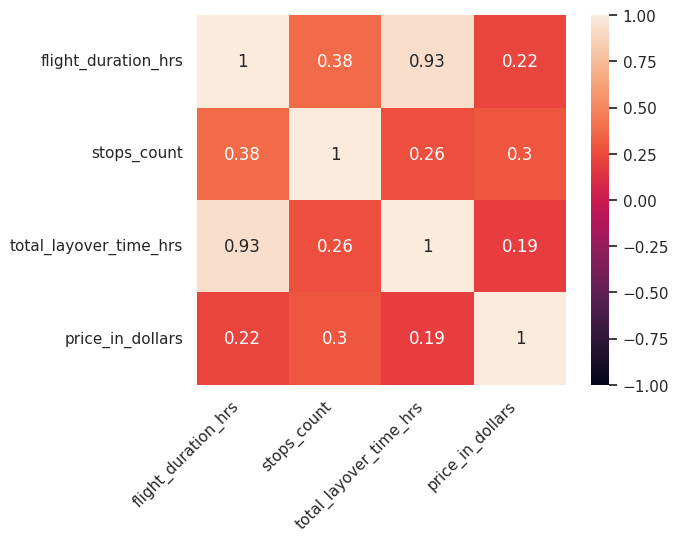

In [35]:
corr = flights_dataset.corr()
ax = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, square=True)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

##### We can make the following conclusions.
###### 1. flight duration is highly correlated with total layover time, which makes sense becuase the higher the layover time, the higher the flight duration. If we are planning to build an ML model with this dataset, we could safely drop one of those two features.
###### 2. The feature that is most correlated to the price feature, is the number of stops. This also makes sense from simple logic. The more stop points there are, the longer the route the flight takes; hence leading to more cost. From my perspective, I'd expect the price to be low for flights that have more stop points between the departure and arrival airports becuase no one would want to be subjected to the hustle of going through a much longer route if there is a shorter one of course.

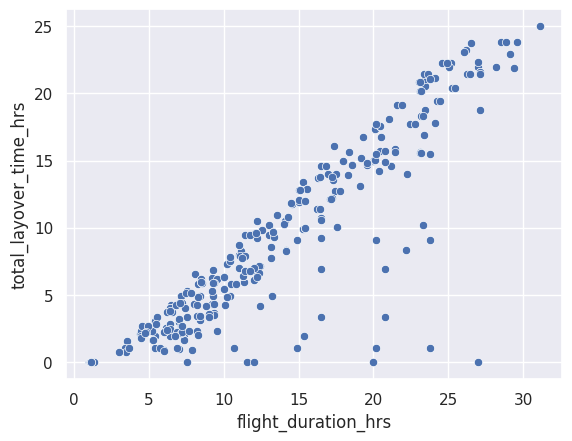

In [36]:
# Let's make a scatter plot between flight duration and total duration time to back up our claim that the two features are highly correleted.
sns.scatterplot(data=flights_dataset, x="flight_duration_hrs", y="total_layover_time_hrs")
plt.show()

###### It seems like even though the flight duration is highly correlated with the total layover time, there are few exceptions. I can see a flight whose duration is aobut 27 hours, while its layover time is zero. This in my opinion could be as a result of the layover time not available or the flight actually has no overtime. For instance, if the flight first goes to Ethiopia (in Africa) and without any layover time, a transfer is made and the passengers are sent to Stockholm, the flight duration could be high as in this case. But this is rather a rare case

#### Now, I guess it's time to visualize the individual features to find out their distributions. For this, we will be skipping the 'website' feature since my interest is not on the website from which a particular flight details was scrapped from.

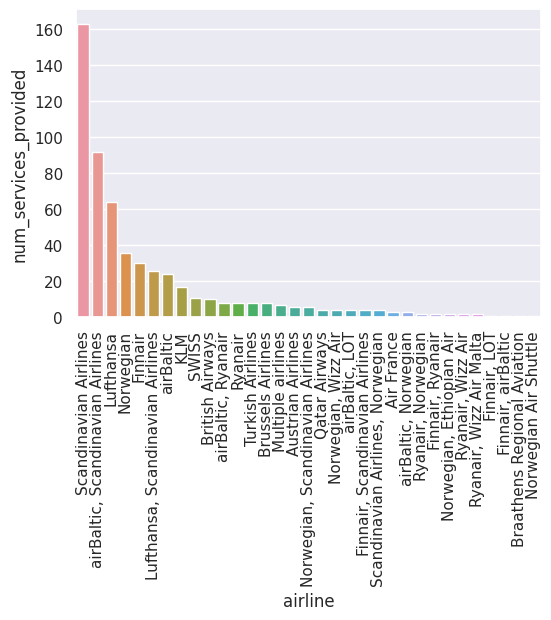

In [37]:
# Let's visualize the flight_company features, to see whihc flight companies provide more services from Helsinki to Stockhlom
labels = flights_dataset['airline'].value_counts().keys().tolist()  # keys are labels
values = flights_dataset['airline'].value_counts().values.tolist()  # number of occurance is the number of services provided

data_dict = {"airline": labels, "num_services_provided": values}
dviz = pd.DataFrame(data_dict)

plt.figure(figsize=(6,4))
ax = sns.barplot(data=dviz, x='airline', y='num_services_provided')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

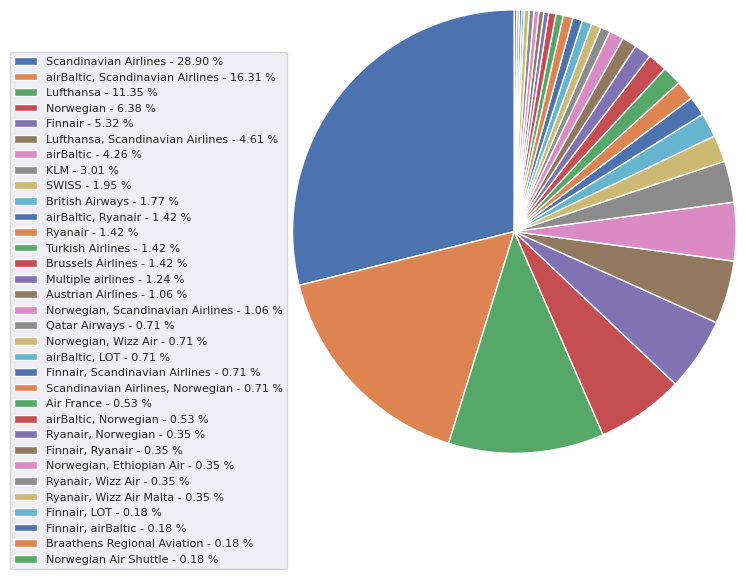

In [38]:
# Let's plot the equivalent pie chart for easy visualisation and stats

percentages = 100.*dviz.num_services_provided/dviz.num_services_provided.sum()

patches, texts = plt.pie(dviz.num_services_provided, startangle=90, radius=1.5)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(dviz.airline, percentages)]

sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, dviz.num_services_provided), key=lambda x: x[2], reverse=True))

plt.legend(patches, labels, loc='upper right', bbox_to_anchor=(-0.1, 1.), fontsize=8)
plt.show()

#### Well ... Scandinavian Airlines clearly takes the lead in flight services from Helsinki to Stockholm, with 'Air Baltic in conjunction with Scandinavian Airlines' taking the second spot. Norwegian Air Shuttle happens to provide the least number of services. However, let's not forget that this data is just for a specific date. It could just so happen that this data is only accurate for our chosen date of the flight (27-11-2023). Another thing to note is that, for a flight route that has multiple airlines, I consider them as one airline. That is why we have something like "airBatic, Norwegian" as an airline. And the reason is simple, these two airlines combine to convey passengers from Helsinki to Stockholm so it wouldn't make much sense to consider them separately becuase then, there will be bias since the departure and destination points won't be the same for all airlines

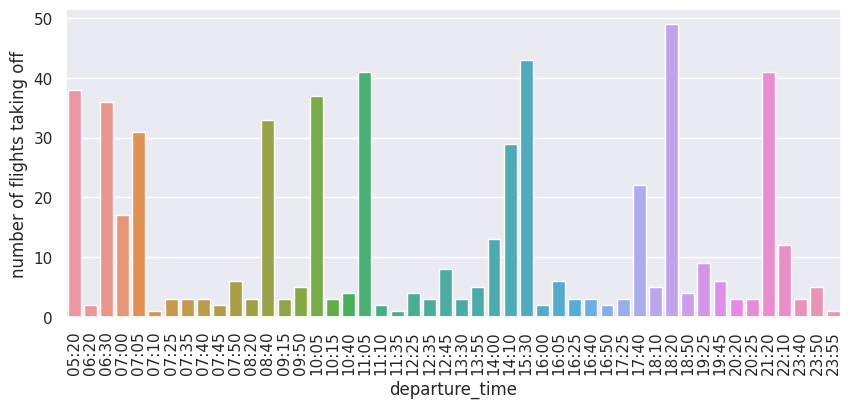

In [39]:
# Let's visualize take-off times. When does these flights take off?

labels = flights_dataset['departure'].value_counts().keys().tolist()  # keys are labels
values = flights_dataset['departure'].value_counts().values.tolist()  # number of occurance is the number of services provided

data_dict = {"departure_time": labels, "number of flights taking off": values}
dviz = pd.DataFrame(data_dict)
dviz = dviz.sort_values(by=['departure_time'])
plt.figure(figsize=(10,4))
ax = sns.barplot(data=dviz, x="departure_time", y="number of flights taking off")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

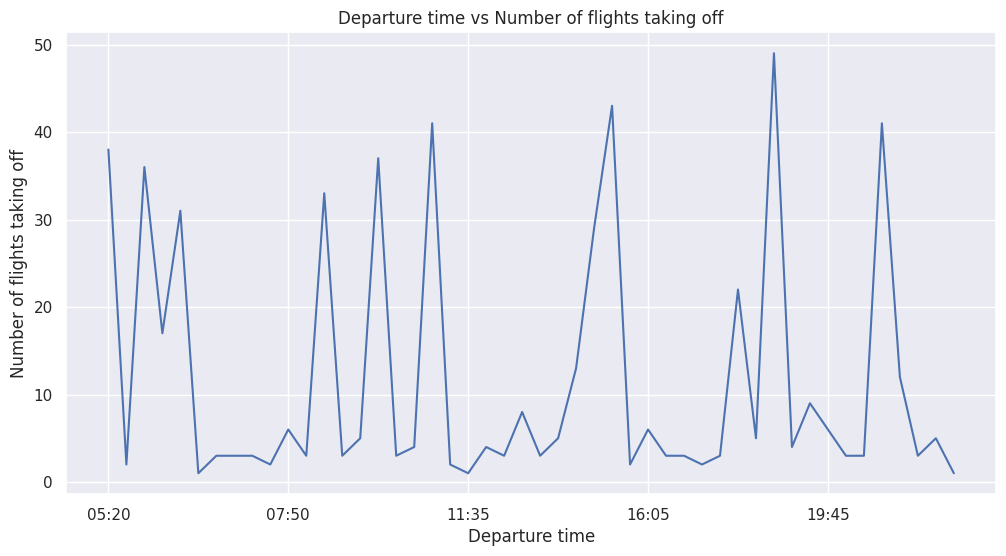

In [40]:
# Let's visualilze the take-off times with a line chart
dviz.plot('departure_time', 'number of flights taking off', figsize=(12,6), legend=False)
plt.title("Departure time vs Number of flights taking off")
plt.xlabel("Departure time")
plt.ylabel("Number of flights taking off")
plt.show()

##### Huuu! That was a lot of work. At least for me :). It seems like most of the flights take off between 05:00 - 07:05, 08:40 - 11:05, 14:00 - 15:30 and 17:40 - 22:00. In other times, the number of flights taking off is not as many as the time intervals specified. However, let's not forget that it might just be that the same flights details are being taken from different websites hence the higher number of flights taking off within a specific time interval. But anyways, it's soothing to know that most flights take off at 11:05. My favorite time to fly, I don't know why, lol

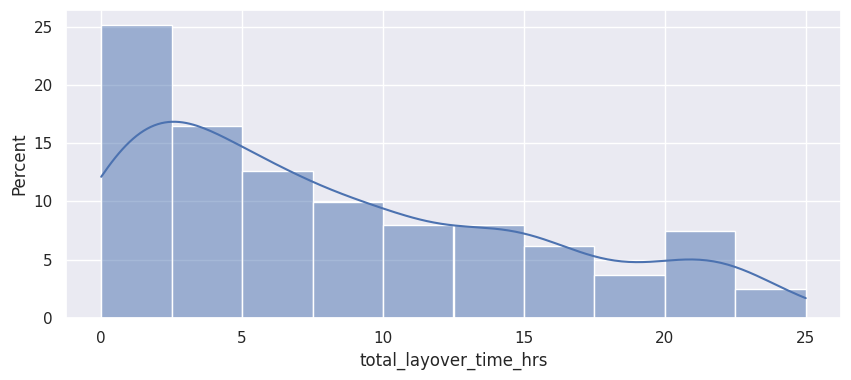

In [41]:
# Since flight duration and total layove time are highly correlated, visualizing one of them will be enough for us.
plt.figure(figsize=(10,4))
sns.histplot(flights_dataset.total_layover_time_hrs, stat="percent", binwidth=2.5, kde = True)
plt.show()#plt.subplot(2,1,2)

#### What do you see?  For me I can observe that over 55 % (26 + 16 + 14) of flights that about 7.5 hours ( 7 hrs 30 mins) to reach the destination. In contrast, about 10% of the flights take 18 or more hours to reach the destination. It is also worth mentioning that over 25% of the flights reach the destination in 2.5 hours ( 2 hours 30 mins)or less. This gives me the intuition that around 25% of the flights are direct flights (from Helsinki to Stockholm)

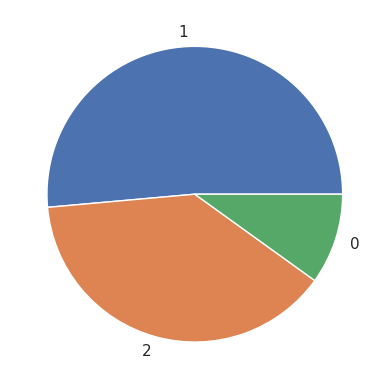

In [42]:
# Let's visualize the number of stops
labels = flights_dataset['stops_count'].value_counts().keys().tolist()  # keys are labels
values = flights_dataset['stops_count'].value_counts().values.tolist()  # number of occurance is the number of services provided

data_dict = {"number_of_stops": labels, "count": values}
dviz = pd.DataFrame(data_dict)

plt.pie(x=dviz['count'], labels=dviz["number_of_stops"])
plt.show()

In [43]:
# I think it would be nice to visualize how the number of stops vary with the price of the flight tickets.
# The graph below is interactive, you can run the cursor over each point, to obtain more information.
px.scatter(flights_dataset, x=flights_dataset.stops_count,
                 y=flights_dataset.price_in_dollars, color='airline')

#### It is evident that direct flights cost less than 200 dollars, while flights with one or more stops costs more on average. By sliding the cursor over the various data points, you will notice that the most cheapest flight ticket is from Norwegian airline, while the most expensive is from "Lufthansa, Scandinavian Airlines". It's operated by two airlines (there is a transit)

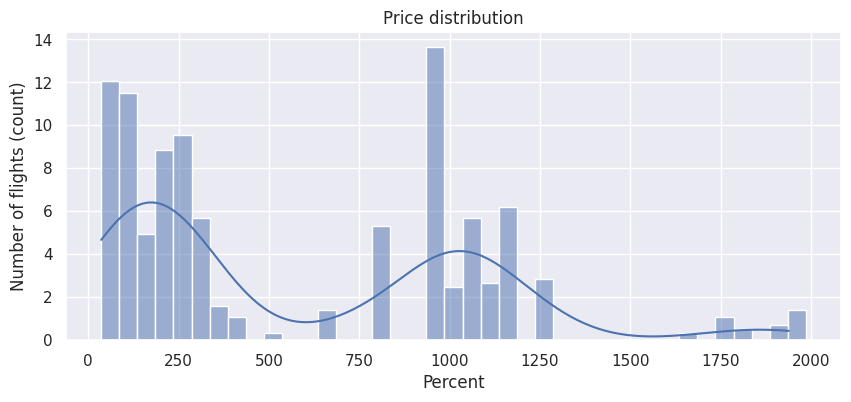

In [44]:
# The monetary affairs. Let's check the distribution of the prices

plt.figure(figsize=(10,4))
sns.histplot(flights_dataset.price_in_dollars, stat="percent", binwidth=50, kde = True)
plt.title("Price distribution")
plt.xlabel("Percent")
plt.ylabel("Number of flights (count)")
plt.show()

#### Hmmm, almost 50% of the flight tickets cost 500 dollars or less, with very few flights (around 4%) costing over 1700 dollars. This group probably represent the flights with over 20 hours of layover time. The average price is around 650 dollars. Please always bear in mind that these figures are prone to change depending on when the data is scrapped. The information provided here can vary

## That was a lot of insights. It's time to allow users to interact with our program to find the best flight options available.

# Interaction with Users
#### The instructions are as follow

##### The user inputs certain preferences for the flight, e.g., price ranges, trip duration ranges (how long from departure to destination), whether the flight is direct or has one or more stops (if it has stops then layover duration), flight company from available options etc.
##### • The user can choose the criteria based on which the flights should be sorted.
##### • The code returns the sorted list of all flights based on the above criteria.
##### • The user should be able to input the earliest convenient time of departure on the departure day from your list, maximum travel time (trip duration from departure to destination) and choose a preferred airline company from available options and get the following information:

###### Cheapest flight for the preselected data with the following details:
###### § Total duration of the flight?
###### § Whether the cheapest flight is direct or has one or more stops?
###### § If it is not direct how long is the layover and in which city? If it has multiple stops, print all layovers.
###### § Type of the aircraft where available, etc.
###### o Fastest flight for the preselected data with the same details as above.

In [45]:
# let's first define helper functions to perform the above functions
# Actually no one wants to pay more for a flight, there's no need for a min_price, but let's just keep it for formality sake
def  get_price_range() -> float:
  """
    Get preferred price range from user.
    Returns: preferred maximum price range for the flight
  """
  max_price:float

  print("Please provide the value in the required data types to ensure a correct output\n")
  status:bool = False # turns through upon successfully getting all values from user
  while not status:
      try:
          max_price = float(input("Please provide value for maximum price range in dollars (float/int): "))
          if (max_price > 0.0):
            status = True
          else:
            print("Price can not be negative. Input a possitive number\n")
      except ValueError:
          print("Provided value is not of type 'float' or 'int'\n")
          continue
  return max_price

####################################### Trip duration #################################################
def  get_trip_duration() -> float:
  """
    Get preferred trip duration range from user.
    Returns: Preferred maximum trip duration for the flight
  """
  max_trip_duration:float

  print("Please note than you are to provide your response in hours as a flaot.(eg. 2hrs 30min will be 2.5, 45mins will be 0.75)")
  status:bool = False # turns through upon successfully getting all values from user
  while not status:
      try:
          max_trip_duration = float(input("Please provide value for maximum trip duration in hours (float/int): "))
          if (max_trip_duration > 0.0):
            status = True
          else:
            print("Duration can not be negative. Input a possitive number\n")
      except ValueError:
          print("Provided value is not of type 'float' or 'int'\n")
          continue
  return max_trip_duration

###################################### stop type (direct or stops?)########################################
def  get_stops_option() -> int:
  """
    Get preferred flight type ( direct or with stops).
    Returns: Preferred flight type
  """
  number_of_stops:int

  print("Please note than you are to provide your response as an int.(i.e.,  0, 1, 2, 3, or -1)")
  status:bool = False # turns through upon successfully getting all values from user
  while not status:
      try:
          number_of_stops = int(input("Please choose your preferred flight type.\n0. Direct\n\
1. 1 stop\n2. 2 stops\n3. 3 or more stops\n4. Enter -1 to choose all available options\n"))
          if number_of_stops not in [-1, 0, 1, 2, 3]:
            print("Your response should be in the range 0-3 inclusive or -1\n")
            continue
          else:
            status = True
      except ValueError:
          print("Provided value is not of type 'int'\n")
          continue
  return number_of_stops

  ##################################### layover duration is stops type is not direct #########################
def  get_layover_duration() -> float:
  """
    Get preferred layover duration range from user.
    Returns: Preferred maximum layover duration of the flight
  """
  max_layover_duration:float

  print("Please note than you are to provide your response in hours as a flaot.(eg. 2hrs 30min will be 2.5, 45mins will be 0.75)")
  status:bool = False # turns through upon successfully getting all values from user
  while not status:
      try:
          max_layover_duration = float(input("Please provide value for maximum layover duration in hours (float/int): "))
          if (max_layover_duration >= 0.0):
            status = True
          else:
            print("Layover time can not be negative. Input must be a possitive number\n")
      except ValueError:
          print("Provided value is not of type 'float' or 'int'\n")
          continue
  return max_layover_duration
################################################# Preferred Airline ##################################################
def  get_preferred_airline(flights_dataset) -> str:
  """
    Get preferred layover duration range from user.
    Returns: Preferred airline for the intended flight
  """
  preferred_airline:str
  print("Please note than you are to provide your response as an int. Choose the index of your preferred airline")
  available_airlines_list = flights_dataset.airline.unique()
  available_airlines = dict(enumerate(available_airlines_list))
  while True:
    print("Please choose an airline from the options below")
    for i in available_airlines:
      print(f"{i}. {available_airlines[i]}")
    try:
      preferred_airline_index = int(input("Please choose the index of your preferred airline or enter -1 to choose all flights (int): "))
      if preferred_airline_index not in [-1] + list(range(0, len(available_airlines))):
        print("Chosen number is out of index or not equal to -1\n")
        continue
      else:
        if preferred_airline_index == -1:
          preferred_airline = str(preferred_airline_index)  # this is needed becuase the return type is a string.
        else:
          preferred_airline = available_airlines[preferred_airline_index]
        break    # break from the loop becuase everything has gone well
    except ValueError:
      print("Provided value is not of type or 'int'\n")
      continue
  return preferred_airline

######################################### Sorting Criteria ###############################################################
def  get_sorting_criterion(flights_dataset) -> str:
  """
    Get the feature on which sorting should be performed
    Returns: The preferred feature on which sorting is to be done.
  """
  preferred_sorting_feature:str
  print("Please note than you are to provide your response as an int. Choose the index of your preferred sorting feature")
  unused_features = ['website', 'arrival', 'layover_info']  # do not sort based on these features (they have less info about the flight)
  available_feature_list = [feature for feature in flights_dataset.columns if feature not in unused_features]
  sorting_features = dict(enumerate(available_feature_list))
  while True:
    print("Please choose your preferred sorting criterion from the options below")
    for i in sorting_features:
      print(f"{i}. {sorting_features[i]}")
    try:
      preferred_feature_index = int(input("Please choose the index of your preferred sorting criterion (int): "))
      if preferred_feature_index not in list(range(0, len(sorting_features))):
        print("Chosen number is out of index\n")
        continue
      else:
        preferred_sorting_feature = sorting_features[preferred_feature_index]
        break    # break from the loop becuase everything has gone well
    except ValueError:
      print("Provided value is not of type 'float' or 'int'\n")
      continue
  return preferred_sorting_feature

In [46]:
# It's time to interact with the user. Let's define a helper funtion to take care of this
def best_flights_options_sorted(dataset=flights_dataset) -> pd.DataFrame:
  """
    Interacts with the user to find the best possible flight options for her and returns a sorted list of the best possible flight options
    Arguments:
      dataset: the dataset to perform the sorting on.
    Return: a dataframe that is sorted based on the user's choice
  """
  ###################################### Get the user preferences ##############################################
  # Get price range
  max_price = get_price_range()
  # just for a good-looking output
  print("####################################################################################################################################")
  # Get trip duration range
  max_duration = get_trip_duration()
  print("####################################################################################################################################")
  # Get the number of preferred stops
  num_stops = get_stops_option()
  print("####################################################################################################################################")
  if num_stops > 0:   # 0 means direct flight. (if flight is direct, no need to get layover time range from the user)
    # Get layover duration preference
    max_layover_time = get_layover_duration()
    print("####################################################################################################################################")
  # Get airline choice
  preferred_airline = get_preferred_airline(dataset)
  print("####################################################################################################################################")
  # Get sorting criterion  (which feature to sort data on?)
  sorting_feature = get_sorting_criterion(dataset)

  # Filter the dataset according to the options specified by the user

  # Filter out data entries for which price is more than max_price
  filtered_df = dataset.loc[dataset['price_in_dollars'] <= max_price]
  # Filter out data entries for which the flight duration is more than max_duration
  filtered_df = filtered_df.loc[filtered_df['flight_duration_hrs'] <= max_duration]
  # Only consider flights with the user's desired number of stops
  if num_stops != -1:  # only filtered if user choose a specifil number of stops, else consider all available number of stops
    filtered_df = filtered_df.loc[filtered_df['stops_count'] == num_stops]
  if num_stops > 0:   # only consider filtering the data based on layover time if number of stops > 0 (flight is not direct)
    # Filter out data entries for which the flight duration is less more than max_layover_time
    filtered_df = filtered_df.loc[filtered_df['total_layover_time_hrs'] <= max_layover_time]
  if preferred_airline != str(-1):   # -1 means consider all available airlines
    # Only consider the user's desired airline company
    filtered_df = filtered_df.loc[filtered_df['airline'] == preferred_airline]

  # SORT THE DATA ACCORDING TO THE SORTING CRITERION (FEATURE) SELECTED
  sorted_data = filtered_df.sort_values(by=[sorting_feature])

  # return the filtered dataset
  return sorted_data




In [58]:
# Let user input their earliest convinient departure time and set the cheapest flight options for them
def get_cheapest_fastest_flight_option(filtered_sorted_dataset):
  """
  Takes earliest convinient departure time from the user and prints the cheapest flight details
  Arguments:
    filtered_
  """
  status = False   # This will evaluate to true when the user successfully provides the time in the required format.
  print("Please pay attention to the required format!")
  while (not status):
      # Get earliest convinient time
      try:
        earliest_time = datetime.datetime.strptime(input("Please enter your ealiest convinient departure time (specify time in 24hr format - HH:MM ): "), "%H:%M");
        earliest_time = earliest_time.strftime("%H:%M")
        status = True   # This will cuase breaking out of the loop
      except:
        print("Incorrect time! Please enter time in HH:MM format")
        continue

  if len(filtered_sorted_dataset)  > 0:
    # filter out data entries with departure time earlier than the user's specified earliest convinient departure time.
    filtered_df = filtered_sorted_dataset.loc[filtered_sorted_dataset['departure'] >= earliest_time]
    filtered_df.reset_index(drop=True, inplace=True)
    if len(filtered_df) > 0:
      # Now, sort the data based on price and print the results of the first option.
      cheapest_flights_sorted = filtered_df.sort_values(by=['price_in_dollars'])
      cheapest_flights_sorted.reset_index(drop=True, inplace=True)
      # Print details of first flight.
      print("#############################################################################################################################")
      print("THE CHEAPEST FLIGHT OPTION BASED ON YOUR SELECTION CRITERIA IS:")
      print(f"Airline company: {cheapest_flights_sorted.loc[0, 'airline']}")
      print(f"Departure time: {cheapest_flights_sorted.loc[0, 'departure']}")
      print(f"Flight duration: {cheapest_flights_sorted.loc[0, 'flight_duration_hrs']}")
      if cheapest_flights_sorted.loc[0, 'stops_count'] == 0:     # check whether flight is direct
        print(f"Number of layovers: Direct")
      else:
        print(f"Number of layovers: {cheapest_flights_sorted.loc[0, 'stops_count']}")
        print(f"Layover information: {cheapest_flights_sorted.loc[0, 'layover_info']}")   # This info is not needed for a direct flight
        print(f"Total layover time: {cheapest_flights_sorted.loc[0, 'total_layover_time_hrs']}")
      print(f"Price: ${cheapest_flights_sorted.loc[0, 'price_in_dollars']}")
      print("#############################################################################################################################")
      # sort by total duration of the flight, followed by price.
      fastest_flights_sorted = filtered_df.sort_values(by=['flight_duration_hrs', 'price_in_dollars'])
      fastest_flights_sorted.reset_index(drop=True, inplace=True)
      print("THE FASTEST FLIGHT OPTION BASED ON YOUR SELECTION CRITERIA IS:")
      print(f"Airline company: {fastest_flights_sorted.loc[0, 'airline']}")
      print(f"Departure time: {fastest_flights_sorted.loc[0, 'departure']}")
      print(f"Flight duration: {fastest_flights_sorted.loc[0, 'flight_duration_hrs']}")
      if fastest_flights_sorted.loc[0, 'stops_count'] == 0:     # check whether flight is direct
        print(f"Number of layovers: Direct")
      else:
        print(f"Number of layovers: {fastest_flights_sorted.loc[0, 'stops_count']}")
        print(f"Layover information: {fastest_flights_sorted.loc[0, 'layover_info']}")   # This info is not needed for a direct flight
        print(f"Total layover time: {fastest_flights_sorted.loc[0, 'total_layover_time_hrs']}")
      print(f"Price: ${fastest_flights_sorted.loc[0, 'price_in_dollars']}")
    else:
      print(f"No flight found for earliest convinient time: {earliest_time}")
  else:
    print("Provided am empty dataset!")

## Driver Program

In [59]:
"""
  Lets get the flights options based on the user's selection criteria.
  Please re-run this cell to input new filtering values/criteria
"""

best_flight_options = best_flights_options_sorted()
best_flight_options.reset_index(drop=True, inplace=True)   # reset the index after the filtering process1

Please provide the value in the required data types to ensure a correct output

Please provide value for maximum price range in dollars (float/int): 350
####################################################################################################################################
Please note than you are to provide your response in hours as a flaot.(eg. 2hrs 30min will be 2.5, 45mins will be 0.75)
Please provide value for maximum trip duration in hours (float/int): 5
####################################################################################################################################
Please note than you are to provide your response as an int.(i.e.,  0, 1, 2, 3, or -1)
Please choose your preferred flight type.
0. Direct
1. 1 stop
2. 2 stops
3. 3 or more stops
4. Enter -1 to choose all available options
-1
####################################################################################################################################
Please note than you are to pro

In [60]:
# Display the best flight opptions available
"""
  Uncomment the line below if you wish to see all flight options
"""
#pd.options.display.max_rows = None
best_flight_options

,website,airline,departure,arrival,flight_duration_hrs,stops_count,layover_info,total_layover_time_hrs,price_in_dollars
0,momondu.com,Braathens Regional Aviation,11:35,11:45 am,1.10,0,,0.00,72.0
1,momondu.com,Finnair,07:35,7:45 am,1.10,0,,0.00,85.0
2,momondu.com,Finnair,12:35,12:35 pm,1.00,0,,0.00,84.0
3,momondu.com,Finnair,08:20,8:25 am,1.05,0,,0.00,85.0
4,hotwire.com,Finnair,07:35,7:45am,1.17,0,,0.00,126.0
5,momondu.com,Finnair,10:05,10:25 am,1.20,0,,0.00,105.0
6,momondu.com,Finnair,17:25,5:30 pm,1.05,0,,0.00,122.0
7,momondu.com,Finnair,10:05,10:25 am,1.20,0,,0.00,105.0
8,momondu.com,Finnair,19:45,8:00 pm,1.15,0,,0.00,117.0
9,momondu.com,Finnair,07:10,7:25 am,1.15,0,,0.00,154.0


## Now, based on the best flight options, find the cheapest and fastest option for the user based on their earliest convinient departure time

In [61]:
# Run program till user decides to quit.
# If the user wishes to change the price range, flight duration, etc, they can re-run the cell above to provide the desired values
while(True):
  try:
    print("\nPlease select an option below to continue..\n")
    choice = int(input("1. Input new departure time preference\n2. Quit program:  "))
    if choice in [1, 2]:
      if(choice == 1):
        get_cheapest_fastest_flight_option(best_flight_options)
        print("######################################################################################################################")
      else:
        print("Quitting program ...\nProgram ended successfully")
        break
    else:
      print("Invalid choice! Choose 1 or 2")
  except ValueError:
    print("Please make a valid selection. Your response should be either 1 or 2")



Please select an option below to continue..

1. Input new departure time preference
2. Quit program:  1
Please pay attention to the required format!
Please enter your ealiest convinient departure time (specify time in 24hr format - HH:MM ): 06:00
#############################################################################################################################
THE CHEAPEST FLIGHT OPTION BASED ON YOUR SELECTION CRITERIA IS:
Airline company: Norwegian
Departure time: 16:40
Flight duration: 1.0
Number of layovers: Direct
Price: $36.0
#############################################################################################################################
THE FASTEST FLIGHT OPTION BASED ON YOUR SELECTION CRITERIA IS:
Airline company: Norwegian
Departure time: 16:40
Flight duration: 1.0
Number of layovers: Direct
Price: $36.0
######################################################################################################################

Please select an option below to 